# Bootstrapping percentiles

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1cal0fl/q_determine_confidence_interval_based_on_observed).

> I'm trying to figure out how to determine the confidence interval for the .2 percentile temperature for specific set of observed temperatures (all hourly temperatures during January, February, and December since 2000). I have recordings for 53128 of the 53424 possible hourly recordings.
>
> How would I go about saying that I am X% sure that the actual .2 percentile value is between two numbers? Could anyone provide any insight on how to accomplish this. Thank you.

OP provided a link to the data, so this is a question we can answer!
But as it turns out, the most common form of bootstrap resampling does not work well for this problem.
I'll show what goes wrong, and how to fix it.
And then we'll answer a follow-up question about quantifying the effect of missing data.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/low_percentile.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [58]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [59]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Data

I downloaded the data as a CSV file, which we can read into a Pandas `DataFrame`.

In [60]:
# download the data

download('https://github.com/AllenDowney/DataQnA/raw/main/data/temperature_data_ama.csv')

'temperature_data_ama.csv'

In [61]:
col = 'Date/Time'
df = pd.read_csv('temperature_data_ama.csv', parse_dates=[col], index_col=col)
df.head()

,tmpf
Date/Time,
2000-01-01 00:00:00,NaN
2000-01-01 01:00:00,NaN
2000-01-01 02:00:00,NaN
2000-01-01 03:00:00,NaN
2000-01-01 04:00:00,NaN


There are 53424 measurements, of which 306 are missing.

In [62]:
len(df)

53424

In [63]:
missing = df['tmpf'].isna()
missing.sum()

306

The range of temperatures is from -8 degF to 89 degF.

In [64]:
data_clean = df['tmpf'].dropna()
data_clean.describe()

count    53118.00000
mean        38.28920
std         13.71636
min         -9.90000
25%         29.00000
50%         37.00000
75%         47.00000
max         89.00000
Name: tmpf, dtype: float64

And the 0.2 percentile is 1 degF.

In [65]:
np.percentile(data_clean, 0.2)

1.0

## Basic bootstrap

The following function takes the cleaned data, resamples it, and computes the 0.2 percentile of the bootstrapped sample.

In [66]:
def bootstrap_percentile(data):
    resampled = np.random.choice(data, size=len(data), replace=True)
    return np.percentile(resampled, 0.2)

If we call this function 1000 times, we get a sample from the sampling distribution of the percentile.

In [67]:
np.random.seed(17)
sample = [bootstrap_percentile(data_clean) for i in range(1000)]

Here's what that sample looks like.

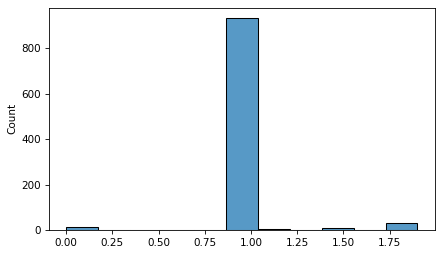

In [68]:
sns.histplot(sample)
decorate(xlabel='')

Immediately we can see that something has gone wrong.
The resampling process produces only 8 unique values. 

In [69]:
np.unique(sample)

array([0.    , 0.234 , 1.    , 1.0936, 1.2106, 1.4   , 1.517 , 1.9   ])

If we try to compute a CI by pulling percentiles from the sample, the results are not credible.

In [70]:
np.percentile(sample, [5, 95])

array([1.    , 1.0936])

This example demonstrates a limitation of bootstrap resampling -- it does not work well when there are a small number of unique values.

However, because the data are temperature measurements, they are actually continuous quantities.
So one option is to replace bootstrapping with a model that generates continuous quantities.
We'll try that with a normal model, see that it does not work, and they try again with KDE.

## Resampling from a normal model

If we look at the CDF of the data, it resembles the characteristic sigma of the normal distribution.

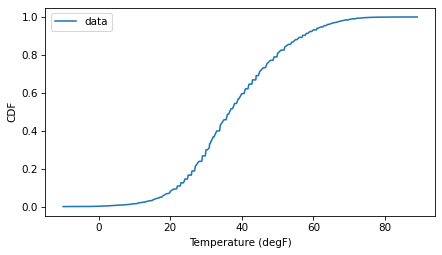

In [71]:
from empiricaldist import Cdf

cdf_data = Cdf.from_seq(data_clean)
cdf_data.plot(label='data')

decorate(xlabel='Temperature (degF)',
         ylabel='CDF')

So let's see how it compares to a normal model.
I'll estimate the parameters by computing the mean and standard deviation of the data.

In [72]:
from scipy.stats import norm

mu = np.mean(data_clean)
sigma = np.std(data_clean)
dist = norm(mu, sigma)

And compute the normal CDF within 4 standard deviations of the mean.

In [73]:
low, high = mu - 4*sigma, mu + 4*sigma
xs = np.linspace(low, high, 201)
ys = dist.cdf(xs)

Here's what the model looks like compared to the data.

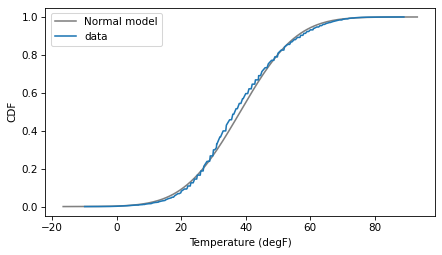

In [74]:
plt.plot(xs, ys, color='gray', label='Normal model')
cdf_data.plot(label='data')

decorate(xlabel='Temperature (degF)',
         ylabel='CDF')

It looks pretty good, but there are places where the data clearly deviate from the model.
That's enough to make me worry, but let's proceed and see how it goes.

The following function takes the cleaned data, generates a random sample from the normal model, and returns the 0.2 percentile of the sample.

In [75]:
def resample_percentile_norm(data):
    resampled = dist.rvs(len(data))
    return np.percentile(resampled, 0.2)

If we call it 1000 times, we hope the result is a sample from the sampling distribution of the percentile.

In [76]:
np.random.seed(17)
sample2 = [resample_percentile_norm(data_clean) for i in range(1000)]

And at first glance it looks good.

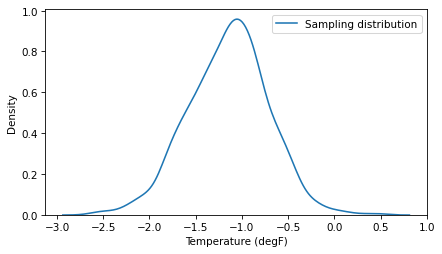

In [77]:
sns.kdeplot(sample2, label='Sampling distribution')
decorate(xlabel='Temperature (degF)',
         ylabel='Density')

But notice that range of the sampling distribution does not include the 0.2 percentile of the data, which is 1.
We can compute a 90% CI, but again, it is not credible.

In [78]:
ci90 = np.percentile(sample2, [5, 95])
ci90

array([-1.84803327, -0.46534009])

To see what went wrong, let's look at the normal model and the data again, this time with the `y` axis on a log scale.
The log scale is like a microscope that lets us see more clearly what is happening in the tail of the distribution.

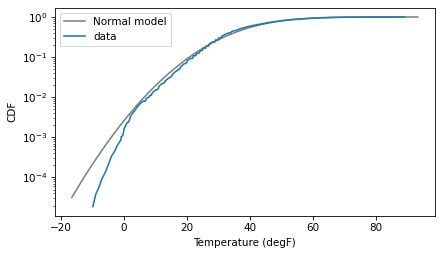

In [79]:
plt.plot(xs, ys, color='gray', label='Normal model')
cdf_data.plot(label='data')

decorate(xlabel='Temperature (degF)',
         ylabel='CDF',
         yscale='log')

On a linear scale, it seemed like the normal model might be good enough; on a log scale, it is clear that they data deviate from the model in the left tail.

In retrospect, it is not a surprise if a simple two-parameter model fails to capture every detail of the distribution -- the world is a complicated place.
So let's try a nonparametric approach.

## Resampling with KDE

We can use kernel density estimation (KDE) to model the distribution of the data, then use the model to resample.
Here's how we estimate the distribution.

In [80]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(data_clean)

To see what the result looks like, we can approximate the density of the model with a discrete PMF.

In [81]:
from empiricaldist import Pmf

pmf_kde = Pmf(kde.pdf(xs), xs)
pmf_kde.normalize()

1.8226580141477107

And then compare the CDF of the model with the CDF of the data.

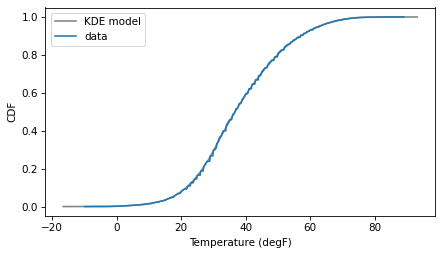

In [82]:
pmf_kde.make_cdf().plot(color='gray', label='KDE model')
cdf_data.plot(label='data')
decorate(xlabel='Temperature (degF)',
         ylabel='CDF')

The result shows that KDE is doing what it is meant to do -- fitting a continuous distribution to the data with minimal assumptions.

The following function takes the cleaned data, uses the KDE model to generate a random sample, and returns the 0.2 percentile of the sample.

In [83]:
def resample_percentile_kde(data):
    resampled = kde.resample(len(data))
    return np.percentile(resampled, 0.2)

If we call it 1000 times, we hope the result is a sample from the sampling distribution of the percentile.

In [84]:
np.random.seed(17)
sample3 = [bootstrap_percentile_kde(data_clean) for i in range(1000)]

And this time we get a better result. The sampling distribution looks good, and it contains the actual percentile of the data.

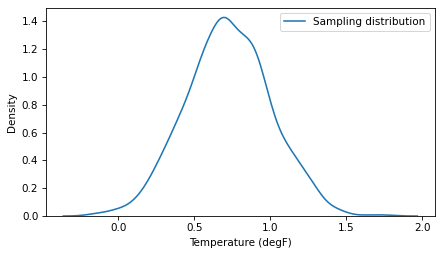

In [85]:
sns.kdeplot(sample3, label='Sampling distribution')
decorate(xlabel='Temperature (degF)',
         ylabel='Density')

And the width of the 90% CI is plausible.

In [86]:
np.percentile(sample3, [5, 95])

array([0.27006571, 1.18702612])

So with a couple of false starts, we have answered the original question.
But it turns out there's more.

## Fill missing values

In a follow-up message, OP wrote:

> Just in case it helps any, here's what I'm ultimately trying to accomplish with this endeavor... I am trying to come up with a plausible way of demonstrating that the .2 percentile value (1 degF) that is derived from this data set is sufficiently representative of what the value would be if there were no missing data points (hourly readings) from the dataset.

OK, that's a different question!
However, the resampling framework can be extended naturally to estimate the effect of missing data.
Here's a function that takes the original data -- including NaNs -- and fills the missing values with a random selection of valid values.
For historical reasons, this way of filling missing values is called "hot deck imputation".

In [88]:
data_nan = df['tmpf']
valid = data_nan.dropna()
missing = data_nan.isna()

def fill_missing(data):
    filled = data.copy()
    filled[missing] = np.random.choice(valid, size=missing.sum(), replace=True)
    return filled

To test it, we can check that the result has no NaNs.

In [92]:
filled = fill_missing(data_nan)
filled.isna().sum()

0

Now we can use `fill_missing` as part of a resampling process.
The following function takes the original data, fills missing values, generates a sample from a KDE model, and returns the 0.2 percentile of the sample.

In [93]:
def resample_percentile_kde_fill(data):
    filled = fill_missing(data)
    kde = gaussian_kde(filled)
    resampled = kde.resample(len(data))
    return np.percentile(resampled, 0.2)

If we call it 1000 times, we get a sample from a distribution that represents the uncertainty of the estimate due to a combination of missing data and random sampling.

In [94]:
np.random.seed(17)
sample4 = [resample_percentile_kde_fill(data_nan) for i in range(1000)]

Here's what the result looks like, compared to the sampling distribution from the previous section, which represents only uncertainty due to random sampling.

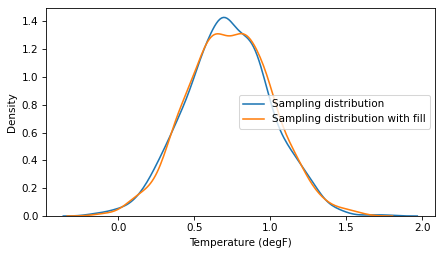

In [95]:
sns.kdeplot(sample3, label='Sampling distribution')
sns.kdeplot(sample4, label='Sampling distribution with fill')
decorate(xlabel='Temperature (degF)',
         ylabel='Density')

The difference does not seem substantial, and the CIs are similar.

In [96]:
np.percentile(sample3, [5, 95])

array([0.27006571, 1.18702612])

In [97]:
np.percentile(sample4, [5, 95])

array([0.29608271, 1.18784825])

To be more precise, we could run this again with a sample size of 10,000 rather than 1000.
But I won't bother because with only about 306 missing values out of 53,424, I did not expect the missing data to affect the results by much, and this result confirms it.
Rather than estimate the CI more precisely, I would conclude that missing data is not a problem, and drop it.

*Data Q&A: Answering the real questions with Python*

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)